In [1]:
import numpy as np
import pandas as pd
import cPickle
from collections import defaultdict
import re

import gensim

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.decomposition import TruncatedSVD

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.constraints import unitnorm
from keras.regularizers import l2
from keras.utils import np_utils
from keras.layers import LSTM, SimpleRNN, GRU
from keras import callbacks

import lda

import matplotlib.pyplot as plt

from __future__ import division
%matplotlib inline

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
Using Theano backend.


# LOAD DATA

In [2]:
def get_idx_from_sent(sent, word_idx_map, max_l, kernel_size=5):
    """
    Transforms sentence into a list of indices. Pad with zeroes.
    """
    x = []
    pad = kernel_size - 1
    for i in xrange(pad):
        x.append(0)
    words = sent.split()
    for word in words:
        if word in word_idx_map:
            x.append(word_idx_map[word])
    while len(x) < max_l+2*pad:
        x.append(0)
    return x

def make_idx_data(revs, word_idx_map, max_l, kernel_size=5):
    """
    Transforms sentences into a 2-d matrix.
    """
    train, val, test = [], [], []
    for rev in revs:
        sent = get_idx_from_sent(rev['text'], word_idx_map, max_l, kernel_size)
        sent = sent+list(rev['ue'])# added
        sent.append(rev['y'])
        if rev['split'] == 1:
            train.append(sent)
        elif rev['split'] == 0:
            val.append(sent)
        else:
            test.append(sent)
    train = np.array(train, dtype=np.int)
    val = np.array(val, dtype=np.int)
    test = np.array(test, dtype=np.int)
    return [train, val, test]

# load data
print "loading data..."
x = cPickle.load(open("../data/twitter-train-val-test_ue.pickle", "rb"))
revs, W, word_idx_map, vocab = x[0], x[1], x[2], x[3]
print "data loaded!"

print 'max_l should be set :', np.max(pd.DataFrame(revs)['num_words'])  

loading data...
data loaded!
max_l should be set : 34


In [3]:
datasets = make_idx_data(revs, word_idx_map, max_l=34, kernel_size=5)  #*** must set max_l

In [4]:
# Train data preparation
N = datasets[0].shape[0]
conv_input_width = W.shape[1]
conv_input_height = int(datasets[0].shape[1]-1)

# For each word write a word index (not vector) to X tensor
train_X = np.zeros((N, conv_input_height), dtype=np.int)
train_Y = np.zeros((N, 2), dtype=np.int)
for i in xrange(N):
    for j in xrange(conv_input_height):
        train_X[i, j] = datasets[0][i, j]
    train_Y[i, datasets[0][i, -1]] = 1
    
print 'train_X.shape = {}'.format(train_X.shape)
print 'train_Y.shape = {}'.format(train_Y.shape)
print '----------------------------------------------------------'


# Validation data preparation
Nv = datasets[1].shape[0]

# For each word write a word index (not vector) to X tensor
val_X = np.zeros((Nv, conv_input_height), dtype=np.int)
val_Y = np.zeros((Nv, 2), dtype=np.int)
for i in xrange(Nv):
    for j in xrange(conv_input_height):
        val_X[i, j] = datasets[1][i, j]
    val_Y[i, datasets[1][i, -1]] = 1
    
print 'val_X.shape = {}'.format(val_X.shape)
print 'val_Y.shape = {}'.format(val_Y.shape)
print '----------------------------------------------------------'



# Test data preparation
Nt = datasets[2].shape[0]

# For each word write a word index (not vector) to X tensor
test_X = np.zeros((Nt, conv_input_height), dtype=np.int)
test_Y = np.zeros((Nt, 2), dtype=np.int)
for i in xrange(Nt):
    for j in xrange(conv_input_height):
        test_X[i, j] = datasets[2][i, j]
    test_Y[i, datasets[2][i, -1]] = 1
    
print 'test_X.shape = {}'.format(test_X.shape)
print 'test_Y.shape = {}'.format(test_Y.shape)
print '----------------------------------------------------------'

# Other Information
max_l = np.max(pd.DataFrame(revs)['num_words'])     #记录最长句子的单词量
print 'number of sentences: ' + str(len(revs))
print 'vocab size: ' + str(len(vocab))
print 'max sentence length: ' + str(max_l)
print 'W shape',W.shape
print 'word_idx_map length',len(word_idx_map)
print 'conv_input_height',conv_input_height
print 'conv_input_width',conv_input_width

train_X.shape = (4003, 55)
train_Y.shape = (4003, 2)
----------------------------------------------------------
val_X.shape = (997, 55)
val_Y.shape = (997, 2)
----------------------------------------------------------
test_X.shape = (5000, 55)
test_Y.shape = (5000, 2)
----------------------------------------------------------
number of sentences: 10000
vocab size: 18154
max sentence length: 34
W shape (18155, 500)
word_idx_map length 18154
conv_input_height 55
conv_input_width 500


# BUILD MODEL

In [5]:
model = Sequential()
model.add(Embedding(W.shape[0], W.shape[1], input_length=conv_input_height, dropout=0.2,weights=[W]))  # input:18155; output:500; input_length:42
model.add(GRU(128, dropout_W=0.2, dropout_U=0.2))  # try using a GRU instead, for fun
model.add(Dense(1))
model.add(Activation('sigmoid'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 55, 500)       9077500     embedding_input_1[0][0]          
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 128)           241536      embedding_1[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1)             129         gru_1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1)             0           dense_1[0][0]                    
Total params: 9319165
_____________________________________________________________________

In [7]:
train_y_label = np.argmax(train_Y,axis=1)
val_y_label =np.argmax(val_Y,axis=1)
test_y_label =np.argmax(test_Y,axis=1)

In [8]:
history = model.fit(train_X, train_y_label, nb_epoch=15,validation_data=(val_X, val_y_label))

Train on 4003 samples, validate on 997 samples
Epoch 1/15
4003/4003 [==============================] - 105s - loss: 0.6724 - acc: 0.5726 - val_loss: 0.6762 - val_acc: 0.5717
Epoch 2/15
4003/4003 [==============================] - 86s - loss: 0.6586 - acc: 0.5938 - val_loss: 0.6653 - val_acc: 0.6068
Epoch 3/15
4003/4003 [==============================] - 85s - loss: 0.6498 - acc: 0.6125 - val_loss: 0.6384 - val_acc: 0.6580
Epoch 4/15
4003/4003 [==============================] - 88s - loss: 0.5668 - acc: 0.7270 - val_loss: 0.6163 - val_acc: 0.6750
Epoch 5/15
4003/4003 [==============================] - 86s - loss: 0.4739 - acc: 0.7909 - val_loss: 0.6371 - val_acc: 0.7011
Epoch 6/15
4003/4003 [==============================] - 79s - loss: 0.3353 - acc: 0.8596 - val_loss: 0.8269 - val_acc: 0.6219
Epoch 7/15
4003/4003 [==============================] - 67s - loss: 0.2839 - acc: 0.8876 - val_loss: 0.7152 - val_acc: 0.6941
Epoch 8/15
4003/4003 [==============================] - 58s - loss: 0.

# MODEL EVALUATION

In [9]:
%matplotlib inline
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

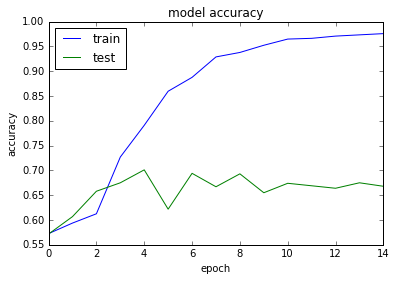

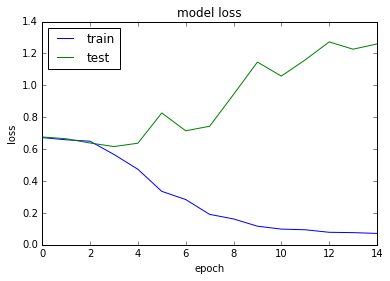

In [10]:
plot_history(history)

In [11]:
print model.metrics_names
print model.evaluate(train_X,train_y_label)
print model.evaluate(test_X,test_y_label)

['loss', 'acc']
4003/4003 [==============================] - 12s    
[0.013431696961544289, 0.99650262303272541]
5000/5000 [==============================] - 15s    
[1.088575205039978, 0.69299999999999995]


# SGD

In [12]:
from keras.optimizers import SGD
sgd = SGD(lr=0.01,nesterov=True)

model_sgd = Sequential()
model_sgd.add(Embedding(W.shape[0], W.shape[1], input_length=conv_input_height, dropout=0.2,weights=[W]))  # input:18155; output:500; input_length:42
model_sgd.add(GRU(128, dropout_W=0.2, dropout_U=0.2))  # try using a GRU instead, for fun
model_sgd.add(Dense(2))
model_sgd.add(Activation('softmax'))
model_sgd.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=['accuracy'])

In [13]:
history_sgd = model_sgd.fit(train_X, train_Y, nb_epoch=15,validation_data=(val_X, val_Y))

Train on 4003 samples, validate on 997 samples
Epoch 1/15
4003/4003 [==============================] - 53s - loss: 0.6942 - acc: 0.4751 - val_loss: 0.6926 - val_acc: 0.5186
Epoch 2/15
4003/4003 [==============================] - 52s - loss: 0.6937 - acc: 0.4954 - val_loss: 0.6945 - val_acc: 0.4814
Epoch 3/15
4003/4003 [==============================] - 45s - loss: 0.6930 - acc: 0.5169 - val_loss: 0.6927 - val_acc: 0.5186
Epoch 4/15
4003/4003 [==============================] - 40s - loss: 0.6938 - acc: 0.4969 - val_loss: 0.6933 - val_acc: 0.4694
Epoch 5/15
4003/4003 [==============================] - 34s - loss: 0.6937 - acc: 0.4969 - val_loss: 0.6934 - val_acc: 0.4814
Epoch 6/15
4003/4003 [==============================] - 34s - loss: 0.6933 - acc: 0.5021 - val_loss: 0.6930 - val_acc: 0.5186
Epoch 7/15
4003/4003 [==============================] - 27s - loss: 0.6941 - acc: 0.4886 - val_loss: 0.6925 - val_acc: 0.5186
Epoch 8/15
4003/4003 [==============================] - 27s - loss: 0.6

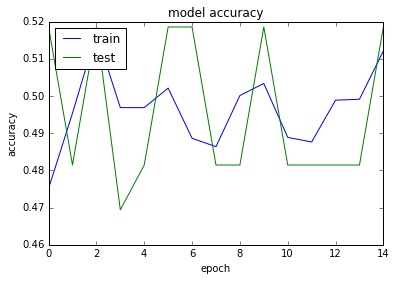

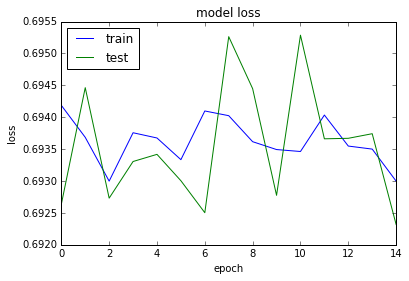

In [14]:
plot_history(history_sgd)

In [15]:
print model_sgd.metrics_names
print model_sgd.evaluate(train_X,train_Y)
print model_sgd.evaluate(test_X,test_Y)

['loss', 'acc']
4003/4003 [==============================] - 5s     
[0.69380663571701984, 0.49762677991506371]
5000/5000 [==============================] - 7s     
[0.69328541946411137, 0.505]
